In [73]:
#http://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture02-wordvecs2.pdf
# biLSTM 기반 감성분석기

In [74]:
!pip install konlpy

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [76]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")


('steam.txt', <http.client.HTTPMessage at 0x7fa53059ebe0>)

In [77]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data))


전체 리뷰 개수 : 100000


In [78]:
total_data['reviews'].nunique() # 유일한 데이터 건수만 나온다. nunique() 99892

99892

In [79]:
total_data['label'].nunique() # 2

2

In [80]:
total_data.drop_duplicates(subset=['reviews'],inplace=True) # 열 기준 중복 제거 drop_duplicates(subset =[])

In [81]:
print('총 샘플의 개수',len(total_data))

총 샘플의 개수 99892


In [82]:
print(total_data.any())

label      True
reviews    True
dtype: bool


In [83]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))


훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973


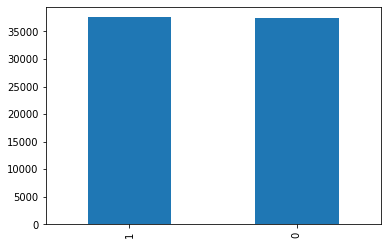

In [84]:
train_data['label'].value_counts().plot(kind = 'bar')



In [85]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [86]:
test_data = test_data.dropna(how='any') # Null 값 제거


In [87]:
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))


전처리 후 테스트용 샘플의 개수 : 24973


In [88]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']


In [89]:
okt=Okt()


In [90]:
train_data['tokenized'] = train_data['reviews'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [91]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)


In [92]:
negative_words

array(['편', '나름', '재밌게', ..., '어렵고', '금방', '끝남'], dtype='<U96')

In [93]:
train_data.head()

,label,reviews,tokenized
17152,1,게임 클리어 할 때까지 계속 새롭고 질리지 않습니다 정말 잘 만든 퍼즐 게임입니다 ...,"[클리어, 할, 때, 까지, 계속, 새, 롭고, 질리, 않습니다, 정말, 잘, 만든..."
59872,0,편 나름 재밌게 했으면 그걸로 멈추는게 좋았네,"[편, 나름, 재밌게, 했으면, 그, 걸, 로, 멈추는게, 좋았네]"
40613,0,할거 드럽게 없음,"[할거, 드럽게, 없음]"
80196,0,ㅈ까라 이건 그거 하나만으로도 살 가치가 없는 겜 내가 저거 때문에 이 겜 시에 ...,"[ㅈ, 까라, 이건, 그거, 하나, 만으로도, 살, 가치, 없는, 내, 저, 거, ..."
35283,0,돈 아깝다,"[돈, 아깝다]"


In [94]:
train_data[train_data.label == 0]['tokenized'].values # 부정어


array([list(['편', '나름', '재밌게', '했으면', '그', '걸', '로', '멈추는게', '좋았네']),
       list(['할거', '드럽게', '없음']),
       list(['ㅈ', '까라', '이건', '그거', '하나', '만으로도', '살', '가치', '없는', '내', '저', '거', '때문', '시', '사서', '지금', '평가', '작성', '중인', '시', '분', '까지', '제대로', '플레이도', '못', '해보고', '개', '고생', '했다']),
       ...,
       list(['망할', '차운전', '레이싱게임', '이나', '마찬가지', '마피아', '레이싱', '안', '산다']),
       list(['처음', '부분', '못', '넘어가겠다']), list(['점프', '어렵고', '금방', '끝남'])],
      dtype=object)

In [95]:
 np.hstack(train_data[train_data.label == 0]['tokenized'].values).shape # 부정어 일렬로 

(507000,)

In [96]:
Counter(negative_words) # 단어별 빈도수 

Counter({'편': 316,
         '나름': 150,
         '재밌게': 256,
         '했으면': 60,
         '그': 1367,
         '걸': 951,
         '로': 3732,
         '멈추는게': 4,
         '좋았네': 1,
         '할거': 113,
         '드럽게': 78,
         '없음': 1021,
         'ㅈ': 499,
         '까라': 5,
         '이건': 647,
         '그거': 127,
         '하나': 860,
         '만으로도': 12,
         '살': 246,
         '가치': 118,
         '없는': 957,
         '내': 1759,
         '저': 749,
         '거': 2151,
         '때문': 843,
         '시': 474,
         '사서': 325,
         '지금': 573,
         '평가': 532,
         '작성': 34,
         '중인': 5,
         '분': 882,
         '까지': 829,
         '제대로': 368,
         '플레이도': 26,
         '못': 3068,
         '해보고': 191,
         '개': 2267,
         '고생': 30,
         '했다': 305,
         '돈': 1685,
         '아깝다': 156,
         '서': 809,
         '전시': 23,
         '많이': 692,
         '즐겼지만': 7,
         '단점': 221,
         '그대로': 176,
         '가져와서': 5,
         '개선': 132,
        

In [97]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20)) # 가장 많이 사용된 언어 20개 


[('안', 4027), ('로', 3732), ('너무', 3475), ('못', 3068), ('으로', 3043), ('하고', 2552), ('할', 2388), ('개', 2267), ('시간', 2204), ('그냥', 2155), ('거', 2151), ('적', 2151), ('하는', 2119), ('왜', 2043), ('에서', 2033), ('것', 2008), ('플레이', 2007), ('나', 1923), ('좀', 1921), ('사람', 1813)]


긍정 리뷰의 평균 길이 : 13.172255813334043
부정 리뷰의 평균 길이 : 13.564854452054794


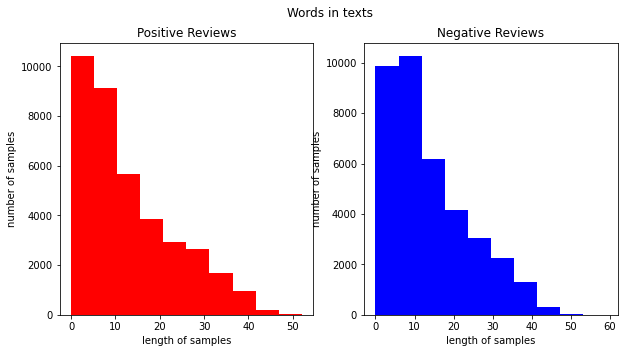

In [98]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()


In [99]:
X_train = train_data['tokenized']


In [100]:
y_train = train_data['label'].values


In [101]:
X_test= test_data['tokenized'].values
y_test = test_data['label'].values



In [102]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)


In [103]:
total_cnt=len(tokenizer.index_word)

In [104]:
threshold = 2

In [105]:
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합


In [106]:
tokenizer.word_counts


OrderedDict([('클리어', 585),
             ('할', 5099),
             ('때', 3884),
             ('까지', 1718),
             ('계속', 1330),
             ('새', 249),
             ('롭고', 72),
             ('질리', 138),
             ('않습니다', 344),
             ('정말', 2550),
             ('잘', 2968),
             ('만든', 525),
             ('퍼즐', 1382),
             ('입니다', 3634),
             ('추천', 3579),
             ('합니다', 2182),
             ('편', 806),
             ('나름', 640),
             ('재밌게', 994),
             ('했으면', 155),
             ('그', 2649),
             ('걸', 1557),
             ('로', 7277),
             ('멈추는게', 4),
             ('좋았네', 1),
             ('할거', 216),
             ('드럽게', 97),
             ('없음', 1350),
             ('ㅈ', 619),
             ('까라', 9),
             ('이건', 966),
             ('그거', 256),
             ('하나', 1682),
             ('만으로도', 70),
             ('살', 473),
             ('가치', 277),
             ('없는', 1486),
             ('내', 3105),
  

In [107]:
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1 # 희귀 단어 카운트
        rare_freq = rare_freq + value # 희귀 단어 빈도수 누적



In [108]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 69561
등장 빈도가 1번 이하인 희귀 단어의 수: 37971
단어 집합에서 희귀 단어의 비율: 54.58662181394747
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.7913144541429777


In [109]:
vocab_size = total_cnt-rare_cnt +2
# 0번은 패딩, 1번 oov 실제 단어는 2번 index 부여

In [110]:
print('단어집합의 크기:',vocab_size)

단어집합의 크기: 31592


In [111]:
tokenizer=Tokenizer(vocab_size,oov_token='OOV')
tokenizer.fit_on_texts(X_train)


In [112]:
tokenizer.index_word

{1: 'OOV',
 2: '로',
 3: '으로',
 4: '안',
 5: '너무',
 6: '할',
 7: '플레이',
 8: '시간',
 9: '하고',
 10: '못',
 11: '적',
 12: '하는',
 13: '것',
 14: '좀',
 15: '에서',
 16: '때',
 17: '입니다',
 18: '추천',
 19: '나',
 20: '사람',
 21: '재미',
 22: '거',
 23: '개',
 24: '스토리',
 25: '하면',
 26: '그냥',
 27: '더',
 28: '생각',
 29: '내',
 30: '잘',
 31: '수',
 32: '왜',
 33: '진짜',
 34: '갓',
 35: '그',
 36: '이다',
 37: '정말',
 38: '아',
 39: '보다',
 40: '함',
 41: '버그',
 42: '같은',
 43: '그래픽',
 44: '돈',
 45: '정도',
 46: '요',
 47: '합니다',
 48: '해서',
 49: '분',
 50: '뭐',
 51: '친구',
 52: '중',
 53: '인데',
 54: '있는',
 55: '환불',
 56: '하지만',
 57: '느낌',
 58: '처음',
 59: '까지',
 60: '일',
 61: '하나',
 62: '멀티',
 63: '말',
 64: '좋은',
 65: '감',
 66: '난이도',
 67: '걸',
 68: '구매',
 69: '저',
 70: '했는데',
 71: '많이',
 72: '엔딩',
 73: '없는',
 74: '실행',
 75: '해',
 76: '서',
 77: '랑',
 78: '서버',
 79: '때문',
 80: '그리고',
 81: '없다',
 82: '세',
 83: '하지',
 84: '퍼즐',
 85: '다시',
 86: '무료',
 87: '없음',
 88: '시작',
 89: '점',
 90: '계속',
 91: '키',
 92: '근데',
 93: '이런',
 94: '도전',
 

In [113]:
X_train[1]

['돌겠네', '진짜', '황숙', '아', '어크', '공장', '그만', '돌려라', '죽는다']

In [114]:
tokenizer.texts_to_sequences(X_train)

[[262, 6, 16, 59, 90, 656, 2017, 1151, 472, 37, 30, 298, 84, 17, 18, 47],
 [173, 231, 135, 1038, 35, 67, 2, 15154, 1],
 [748, 1593, 87],
 [245,
  9127,
  143,
  632,
  61,
  2063,
  341,
  586,
  73,
  29,
  69,
  22,
  79,
  168,
  216,
  116,
  162,
  2469,
  6785,
  168,
  49,
  59,
  299,
  2697,
  10,
  497,
  23,
  2018,
  249],
 [44, 906],
 [76,
  3287,
  71,
  10717,
  183,
  546,
  10718,
  679,
  2431,
  1306,
  164,
  78,
  87,
  198,
  4,
  8509,
  282,
  889,
  8510],
 [1242, 2244, 3, 13321, 5681, 1, 4185, 149, 7552],
 [3288, 100, 1039, 7, 117, 433, 425, 701, 1, 196, 1, 130, 500],
 [2064, 3354, 2470, 1, 416, 1, 6786, 2698, 416, 3, 2838],
 [608],
 [94,
  114,
  3892,
  3485,
  3,
  129,
  34,
  950,
  94,
  105,
  1558,
  1995,
  145,
  28,
  39,
  128,
  40,
  434,
  94,
  114,
  1471,
  233,
  13,
  7996],
 [230, 119, 15, 58, 3, 397, 53, 7137, 73, 153, 14],
 [84,
  6787,
  1,
  1197,
  10719,
  1472,
  202,
  25,
  107,
  406,
  115,
  5,
  22424,
  446,
  3,
  3724,
  17

In [115]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [116]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))


리뷰의 최대 길이 : 59


In [117]:
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 평균 길이 : 13.36811756697233


In [118]:
len(X_train[0])

16

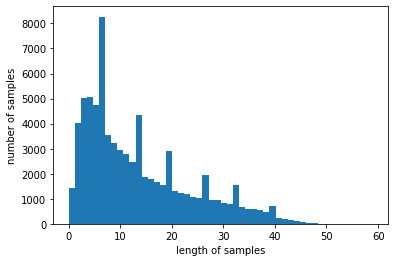

In [119]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [120]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))
max_len = 60
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 60 이하인 샘플의 비율: 100.0


In [121]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)


In [122]:
len(X_train[0])

60

In [123]:
X_train

array([[    0,     0,     0, ...,    17,    18,    47],
       [    0,     0,     0, ...,     2, 15154,     1],
       [    0,     0,     0, ...,   748,  1593,    87],
       ...,
       [    0,     0,     0, ...,     1,    18,   475],
       [    0,     0,     0, ...,   871,   574,  2711],
       [    0,     0,     0, ...,   109,    27,   957]], dtype=int32)

In [124]:
import re
from keras.layers import Embedding, Dense, LSTM, Bidirectional
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
model = Sequential()
model.add(Embedding(vocab_size, 100)) # vocab_size -> 100 차원으로 임베딩
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid')) # 긍부정 하나 


In [125]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         3159200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 3,320,201
Trainable params: 3,320,201
Non-trainable params: 0
_________________________________________________________________


In [126]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

In [127]:
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True) # 모델을 중간중간 저장 // 중단되더라도 중단 직전에 모델이 저장



In [128]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)


Epoch 1/15
235/235 [==============================] - ETA: 0s - loss: 0.5303 - acc: 0.7400
Epoch 00001: val_acc improved from -inf to 0.77963, saving model to best_model.h5
235/235 [==============================] - 8s 36ms/step - loss: 0.5303 - acc: 0.7400 - val_loss: 0.4646 - val_acc: 0.7796
Epoch 2/15
235/235 [==============================] - ETA: 0s - loss: 0.4140 - acc: 0.8150
Epoch 00002: val_acc did not improve from 0.77963
235/235 [==============================] - 8s 34ms/step - loss: 0.4140 - acc: 0.8150 - val_loss: 0.4888 - val_acc: 0.7726
Epoch 3/15
235/235 [==============================] - ETA: 0s - loss: 0.3772 - acc: 0.8356
Epoch 00003: val_acc improved from 0.77963 to 0.78310, saving model to best_model.h5
235/235 [==============================] - 8s 34ms/step - loss: 0.3772 - acc: 0.8356 - val_loss: 0.4602 - val_acc: 0.7831
Epoch 4/15
235/235 [==============================] - ETA: 0s - loss: 0.3535 - acc: 0.8471
Epoch 00004: val_acc did not improve from 0.78310
235

In [129]:
loaded_model = load_model('best_model.h5')
loaded_model.evaluate(X_test, y_test)


781/781 [==============================] - 4s 5ms/step - loss: 0.5184 - acc: 0.7808


[0.5184220671653748, 0.7808433175086975]

In [130]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))


In [131]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')


97.59% 확률로 부정 리뷰입니다.


In [132]:
sentiment_predict('1엄복동입니다')

68.31% 확률로 긍정 리뷰입니다.


In [136]:
sentiment_predict('100 UBD')

51.07% 확률로 부정 리뷰입니다.


In [134]:
sentiment_predict('1 UBD')

51.07% 확률로 부정 리뷰입니다.


In [137]:
sentiment_predict('별 다섯개')

66.65% 확률로 부정 리뷰입니다.


In [138]:
sentiment_predict('별 열개')

53.84% 확률로 부정 리뷰입니다.


In [139]:
sentiment_predict('뭘 본건지 모르겠다')

60.08% 확률로 부정 리뷰입니다.
